In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
sys.path.insert(0, '..//')

In [10]:
import pandas as pd
from timeseries.economic import tariff_creator
from pathlib import Path
from timeseries.common import enums
from datetime import datetime
from timeseries.economic import tariff_functions

# Create Dummy Energy Tariffs

<u> Examples using real world data in the next section. </u>

The timeseries package can be used to create a dummy price profile given a start and end date. This creates a dataframe as seen below made of:

- DUoS Charges - `DUOS_RED`, `DUOS_AMBER` & `DUOS_GREEN` are charges applied during specific times of the day based on how much energy is being used during these times. For example, typically, green is nighttime, amber is daytime & red is usually between 18:00 and 22:00.
- Day / Night Charges - The standard rate paid during the day/night.
- CCL - Cimate Change Levy is a tax paid on energy usage due to its impact on increasing carbon emissions.

In [11]:
start = datetime(2020, 1, 1)
end = datetime(2020, 12, 31)

monthly_dataf = tariff_functions.create_default_import_electricity_data(
    start, end)
monthly_dataf.head()

,CCL,DAY_CHARGE,NIGHT_CHARGE,DUOS_RED,DUOS_GREEN,DUOS_AMBER
Date,,,,,,
2020-01-01,0.00775,0.138323,0.113827,0.0557,0.00035,0.0018
2020-02-01,0.00775,0.138323,0.113827,0.0557,0.00035,0.0018
2020-03-01,0.00775,0.138323,0.113827,0.0557,0.00035,0.0018
2020-04-01,0.00775,0.138323,0.113827,0.0557,0.00035,0.0018
2020-05-01,0.00775,0.138323,0.113827,0.0557,0.00035,0.0018


Now we can combine the different values into a single price profile using `tariff_functions.create_duos_electricity_charges()`. In the below example, the function is re-run for each of the 12 months but it could equally be run just for a single month by passing individual values for each of the DUoS arguments (Red, Amber & Green).

<Axes: title={'center': 'Demo DUoS for electric consumption'}, xlabel='Date', ylabel='DUoS charge (GBP/kWh)'>

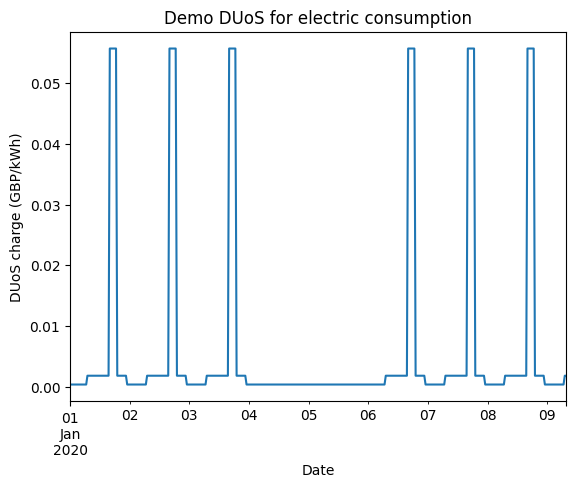

In [12]:
monthly_dataf.reset_index(inplace=True)

monthly_profile_list = [
    tariff_functions.create_duos_electricity_charges(**args)
    for args in monthly_dataf.to_dict("records")
]

duos_charges = pd.concat(monthly_profile_list)

duos_charges.head(400).plot(xlabel="Date",
                            ylabel="DUoS charge (GBP/kWh)",
                            title="Demo DUoS for electric consumption")

Alternatively, you can use `tariff_functions.create_default_import_electricity_tariff_structure()` to create a dummy Tariff structure object and then use `.get_consumption_charges_dataframe()` to create a half-hourly profile of charges which can be plotted individually as below, or use `.sum(axis=1)` to combine into a single price profile.

post_init of CCL
post_init of DUOS
post_init of Energy_Charge
post init


<Axes: >

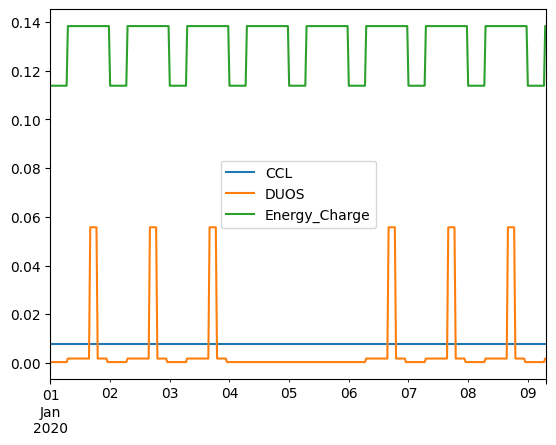

In [13]:
electricity_import_structure = tariff_functions.create_default_import_electricity_tariff_structure(
    start, end)

electricity_import_structure.get_consumption_charges_dataframe().head(400).plot() #.sum(axis=1)

# Create Energy Tariff

Alternatively, you can use your invoice data to create a price profile. By creating a dictionary of invoice paths, connected to their `enums.EnergyCarrier` we can create a new `tariff_creator.EnergyTariffImport()` and then load the dictionary into our object using the `.load_data()` function.

In [14]:
meter_id = 1234
meter_id_2 = 1928

elec_path = Path(r'..//data/example_electric_invoices.csv')
gas_path = Path(r"..//data/example_gas.csv")

invoice_path_dict = {enums.EnergyCarrier.NATURALGAS:gas_path, enums.EnergyCarrier.ELECTRICITY:elec_path}

period_start = pd.to_datetime(start, format='%Y/%m/%d')
period_end = pd.to_datetime(end, format='%Y/%m/%d')

test_site = tariff_creator.EnergyTariffImporter('Test Site')
test_site.load_data(invoice_path_dict)

In [15]:
test_site.get_all_meter_ids()

{<EnergyCarrier.NATURALGAS: 2>: [1234, 5678, 9012, 3456, 7890],
 <EnergyCarrier.ELECTRICITY: 1>: [1928, 9182, 5647]}

## Gas Price Profile

Using the individual meter codes as shown above we can view each sites price profile, here's one of the gas ones. Obviously, gas doesn't have daily variations, however, price changes across the year would be highlighted here.

post_init of CCL
post_init of CCL
post_init of Energy_Charge
post init


<Axes: title={'center': 'Demo consumption price profile'}, xlabel='Date', ylabel='Energy consumption charge (GBP/kWh)'>

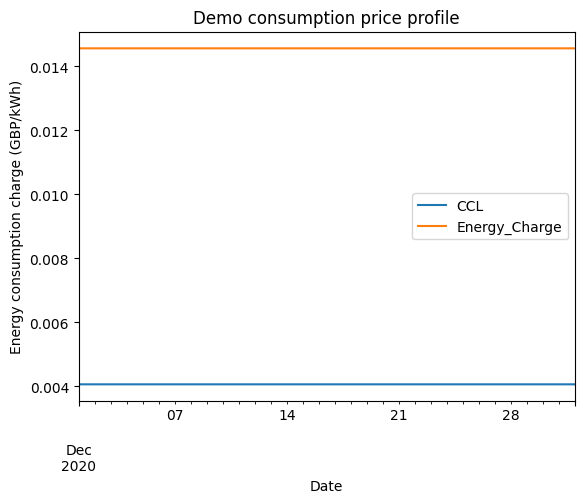

In [16]:
tariff_structure_gas = test_site.get_tariff_structure(meter_id, period_start, period_end)
tariff_structure_gas.get_consumption_charges_dataframe().plot(
    xlabel="Date",
    ylabel="Energy consumption charge (GBP/kWh)",
    title="Demo consumption price profile")

## Electric Price Profile

And here's the electric profile.

post_init of CCL
post_init of DUOS
post_init of Energy_Charge
post init


<Axes: title={'center': 'Demo consumption price profile'}, xlabel='Date', ylabel='Energy consumption charge (GBP/kWh)'>

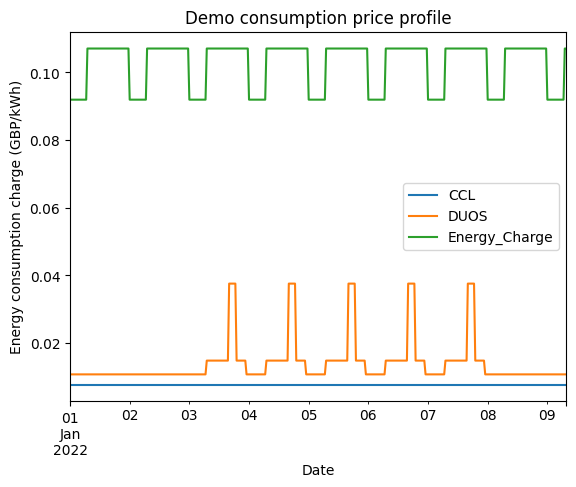

In [22]:
start = datetime(2022, 1, 1)
end = datetime(2022, 12, 31)

period_start = pd.to_datetime(start, format='%Y/%m/%d')
period_end = pd.to_datetime(end, format='%Y/%m/%d')

tariff_structure_elec = test_site.get_tariff_structure(meter_id_2,
                                                       period_start,
                                                       period_end)
tariff_structure_elec.get_consumption_charges_dataframe().head(400).plot(
    xlabel="Date",
    ylabel="Energy consumption charge (GBP/kWh)",
    title="Demo consumption price profile")

## Carbon data

We also have the capability to retrieve carbon intensity from carbonintensity.org.uk API. More example functions can be found in `timeseries.environmental.carbon`.

In [24]:
from timeseries.environmental import carbon

carbon.get_emission_by_date(datetime(2024,1,1))

{'data': [{'from': '2024-01-01T00:00Z',
   'to': '2024-01-01T00:30Z',
   'intensity': {'forecast': 64, 'actual': 64, 'index': 'low'}},
  {'from': '2024-01-01T00:30Z',
   'to': '2024-01-01T01:00Z',
   'intensity': {'forecast': 62, 'actual': 64, 'index': 'low'}},
  {'from': '2024-01-01T01:00Z',
   'to': '2024-01-01T01:30Z',
   'intensity': {'forecast': 65, 'actual': 62, 'index': 'low'}},
  {'from': '2024-01-01T01:30Z',
   'to': '2024-01-01T02:00Z',
   'intensity': {'forecast': 61, 'actual': 71, 'index': 'low'}},
  {'from': '2024-01-01T02:00Z',
   'to': '2024-01-01T02:30Z',
   'intensity': {'forecast': 61, 'actual': 66, 'index': 'low'}},
  {'from': '2024-01-01T02:30Z',
   'to': '2024-01-01T03:00Z',
   'intensity': {'forecast': 67, 'actual': 67, 'index': 'low'}},
  {'from': '2024-01-01T03:00Z',
   'to': '2024-01-01T03:30Z',
   'intensity': {'forecast': 63, 'actual': 64, 'index': 'low'}},
  {'from': '2024-01-01T03:30Z',
   'to': '2024-01-01T04:00Z',
   'intensity': {'forecast': 64, 'actual'